In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):

  plt.figure(figsize=(10,6))
  if type(y) is tuple:
    for y_curr in y:
      plt.plot(x[start:end], y_curr[start:end], format)
  else:
    plt.plot(x[start:end], y[start:end], format) 

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  if legend:
    plt.legend(legend)  

  plt.title(title)

  plt.grid(True)   
  plt.show()

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-04-26 19:57:36--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-04-26 19:57:36 (86.0 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


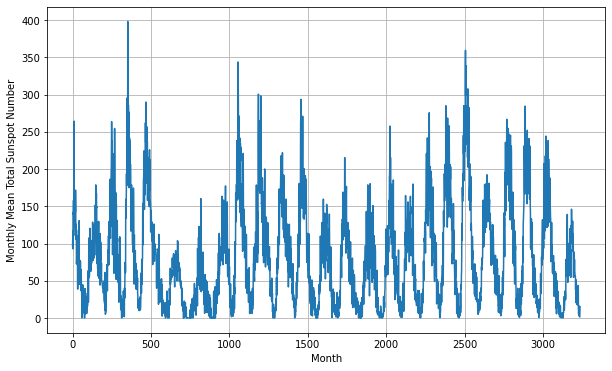

In [5]:
time_step = []
sunspots = []

with open("./Sunspots.csv") as csvfile:

  reader = csv.reader(csvfile, delimiter = ",")

  next(reader)

  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))


time = np.array(time_step) 
series = np.array(sunspots) 

plot_series(time, series, xlabel="Month", ylabel="Monthly Mean Total Sunspot Number")


In [6]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
window_size = 32
batch_size = 32 
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                990       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________


In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer= optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 1s 4ms/step - loss: 117.1896 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 0s 3ms/step - loss: 116.0646 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 0s 3ms/step - loss: 114.8020 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 3ms/step - loss: 113.3983 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 5ms/step - loss: 111.8426 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 0s 3ms/step - loss: 110.1175 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 0s 3ms/step - loss: 108.2100 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 0s 3ms/step - loss: 106.1032 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 0s 3ms/step - loss: 103.7794 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 0s 3ms/step - loss: 101.2158 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

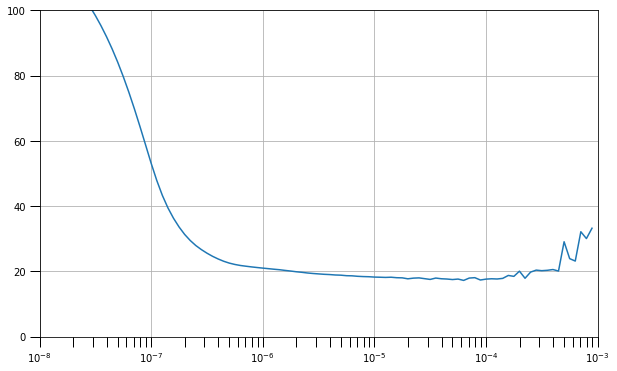

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [13]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [14]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 4ms/step - loss: 34.4179 - mae: 34.9122
Epoch 2/100
93/93 [==============================] - 1s 7ms/step - loss: 20.4359 - mae: 20.9262
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 19.5074 - mae: 19.9993
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 19.0517 - mae: 19.5430
Epoch 5/100
93/93 [==============================] - 0s 3ms/step - loss: 18.5390 - mae: 19.0323
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 18.4049 - mae: 18.8973
Epoch 7/100
93/93 [==============================] - 0s 4ms/step - loss: 18.0752 - mae: 18.5661
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 18.1308 - mae: 18.6225
Epoch 9/100
93/93 [==============================] - 0s 3ms/step - loss: 17.8190 - mae: 18.3108
Epoch 10/100
93/93 [==============================] - 0s 4ms/step - loss: 17.7009 - mae: 18.1922
Epoch 11/100
93/93 [===================

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

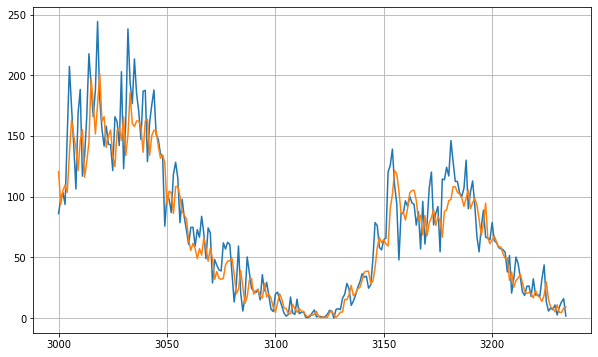

In [16]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [17]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.965371
